# Detecção de fraude no e-commerce

### Bibliotecas básicas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import special
import itertools
from datetime import timedelta
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Carregamento dos dados

#### Compras

In [2]:
fraude_df = pd.read_csv('./datasets/Fraud_Data.csv', header=0)
print(f'Linhas: {fraude_df.shape[0]} | Colunas: {fraude_df.shape[1]}')
fraude_df.head()

Linhas: 151112 | Colunas: 11


,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


Tipos:

In [3]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

Valores nulos:

In [4]:
for col in fraude_df.columns:
    print('# de valores nulos em {}: {}'.format(col, fraude_df[col].isnull().sum()))

# de valores nulos em id: 0
# de valores nulos em cadastro: 0
# de valores nulos em compra: 0
# de valores nulos em valor: 0
# de valores nulos em id_dispositivo: 0
# de valores nulos em fonte: 0
# de valores nulos em browser: 0
# de valores nulos em genero: 0
# de valores nulos em idade: 0
# de valores nulos em ip: 0
# de valores nulos em fraude: 0


Resumo dos dados:

In [5]:
fraude_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


#### Escala de IPs de cada país

In [6]:
ISP_df = pd.read_csv('./datasets/IpAddress_to_Country.csv', header=0)
print(f'Linhas: {ISP_df.shape[0]} | Colunas: {ISP_df.shape[1]}')
ISP_df.head()

Linhas: 138846 | Colunas: 3


,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Tipos:

In [7]:
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip      int64
pais                   object
dtype: object

In [8]:
ip_floats = ISP_df['limite_inferior_ip'].apply(lambda x : not x.is_integer()).sum()
print(f'Número de limites inferiores de IPs com decimal não-zero: {ip_floats}')

Número de limites inferiores de IPs com decimal não-zero: 0


In [9]:
ISP_df['limite_inferior_ip'] = ISP_df['limite_inferior_ip'].astype(int)
ISP_df.dtypes

limite_inferior_ip     int64
limite_superior_ip     int64
pais                  object
dtype: object

Valores nulos:

In [10]:
for col in ISP_df.columns:
    print('# de valores nulos em {}: {}'.format(col, ISP_df[col].isnull().sum()))

# de valores nulos em limite_inferior_ip: 0
# de valores nulos em limite_superior_ip: 0
# de valores nulos em pais: 0


Resumo dos dados:

In [11]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


Valores discrepantes:

In [12]:
display(ISP_df[ISP_df['limite_inferior_ip'] == ISP_df['limite_inferior_ip'].max()])
display(ISP_df[ISP_df['limite_superior_ip'] == ISP_df['limite_superior_ip'].max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


### Limpeza dos dados

In [13]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df['limite_inferior_ip'] <= isp) & (ISP_df['limite_superior_ip'] >= isp)]['pais']
    
    if pais.shape[0] == 1:
        return 'Único'
    elif pais.shape[0] > 1:
        return 'Vários países'
    elif pais.shape[0] == 0:
        if isp > ISP_df['limite_superior_ip'].max():
            return 'Muito grande'
        elif isp < ISP_df['limite_inferior_ip'].min():
            return 'Muito pequeno'
        else:
            return 'Faltando'
            
fraude_df['isp_count'] = fraude_df['ip'].apply(isp_counts)
fraude_df['isp_count'].value_counts()

Único            129146
Muito grande      19383
Faltando           1949
Muito pequeno       634
Name: isp_count, dtype: int64

In [14]:
def ip_para_pais(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)& (ISP_df.limite_superior_ip >= ip)]['pais']
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return 'Faltando'
    elif tmp.shape[0] > 1:
        return 'Erro'

fraude_df['pais'] = fraude_df['ip'].apply(ip_para_pais)
fraude_df['pais'].value_counts()

United States     58049
Faltando          21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Niger                 1
Burundi               1
San Marino            1
Dominica              1
Gambia                1
Name: pais, Length: 182, dtype: int64

### Análise exploratória

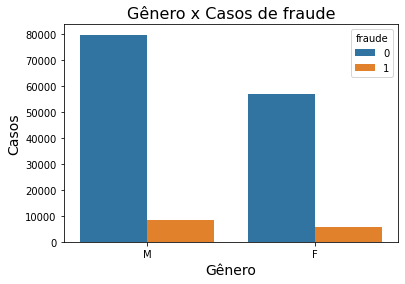

In [15]:
sns.countplot(x='genero', hue='fraude', data=fraude_df)
plt.xlabel('Gênero', fontsize=14)
plt.ylabel('Casos', fontsize=14)
plt.title('Gênero x Casos de fraude', fontsize=16)
plt.show()

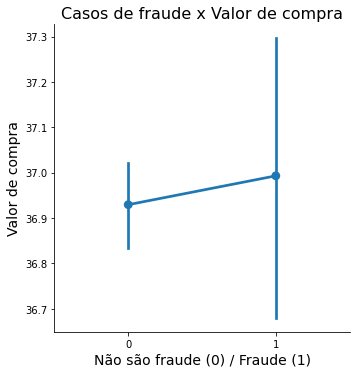

In [16]:
sns.factorplot(x='fraude', y='valor', data=fraude_df)
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Valor de compra', fontsize=14)
plt.title('Casos de fraude x Valor de compra', fontsize=16)
plt.show()

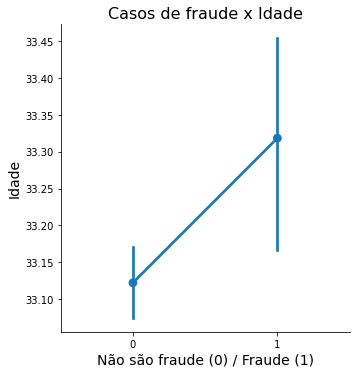

In [17]:
sns.factorplot(x='fraude', y='idade', data=fraude_df)
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Idade', fontsize=14)
plt.title('Casos de fraude x Idade', fontsize=16)
plt.show()

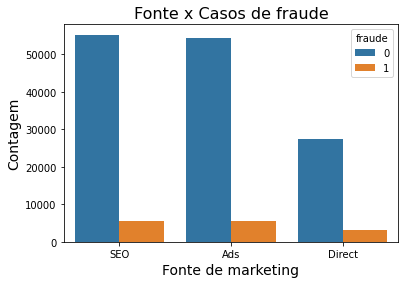

In [18]:
sns.countplot(x='fonte', hue='fraude', data=fraude_df)
plt.xlabel('Fonte de marketing', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Fonte x Casos de fraude', fontsize=16)
plt.show()

####  País de origem x Fraude

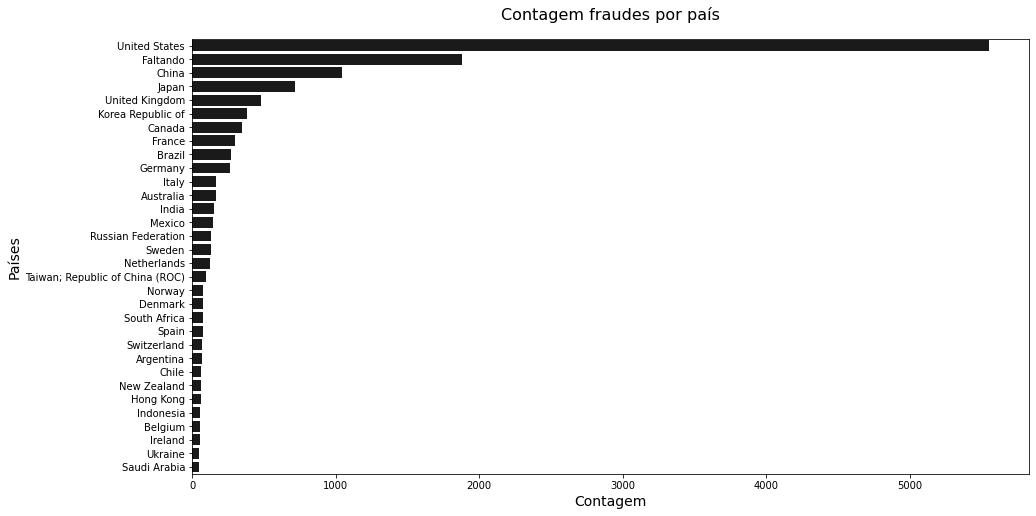

In [19]:
soma_fraudes_por_pais = fraude_df.query('fraude == 1')['fraude'].groupby(fraude_df['pais']).sum().reset_index()
soma_fraudes_por_pais = soma_fraudes_por_pais.sort_values('fraude', ascending=False)

f, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes('muted')
sns.barplot(x='fraude', y='pais', data=soma_fraudes_por_pais.query('fraude >= 50'), label='Total', color='k')
plt.xlabel('Contagem', fontsize=14)
plt.ylabel('Países', fontsize=14)
plt.title('Contagem fraudes por país', fontsize=16, y=1.03)
plt.show()

#### Número de IDs por cliente para cada dispositivo e para cada IP

In [20]:
tmp_df = pd.DataFrame(columns=('fraude', 'id_por_dispositivo', 'id_por_ip'))
tmp_df['fraude'] = fraude_df['fraude']

userid_count = fraude_df.groupby(by=['id_dispositivo']).id.count()
tmp_df['id_por_dispositivo'] = fraude_df['id_dispositivo'].apply(lambda x: userid_count[x])

userid_count2 = fraude_df.groupby(by=['ip']).id.count()
tmp_df['id_por_ip'] = fraude_df['ip'].apply(lambda x: userid_count2[x])

tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip
0,0,1,1
1,0,1,1
2,1,12,12
3,0,1,1
4,0,1,1


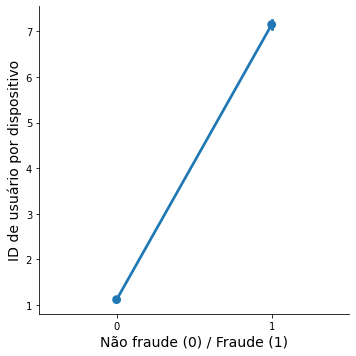

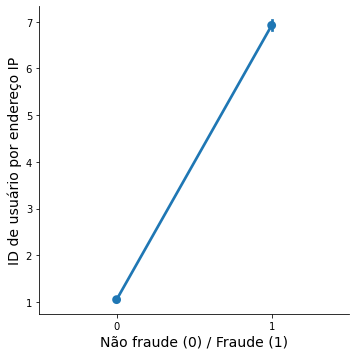

In [21]:
sns.factorplot(x='fraude', y='id_por_dispositivo', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por dispositivo', fontsize=14)

sns.factorplot(x='fraude', y='id_por_ip', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por endereço IP', fontsize=14)
plt.show()

#### Fraude x tempo de compra

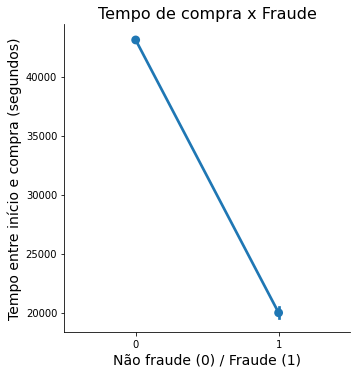

In [22]:
tmp_df['cadastro'] = fraude_df['cadastro'].apply(pd.to_datetime)
tmp_df['compra'] = fraude_df['compra'].apply(pd.to_datetime)
tmp_df['tempo'] = (tmp_df['compra'] - tmp_df['cadastro']).apply(lambda x: x.seconds)

sns.factorplot(x='fraude', y='tempo', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Tempo entre início e compra (segundos)', fontsize=14)
plt.title('Tempo de compra x Fraude', fontsize=16, y=1.03)
plt.show()

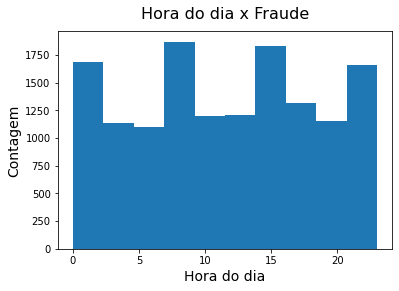

In [23]:
tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel('Hora do dia', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Hora do dia x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

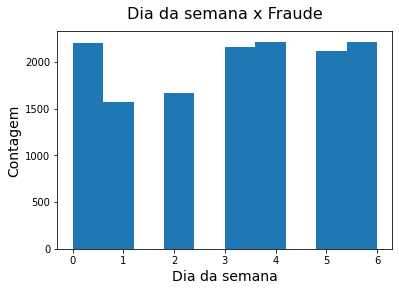

In [24]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel('Dia da semana', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Dia da semana x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

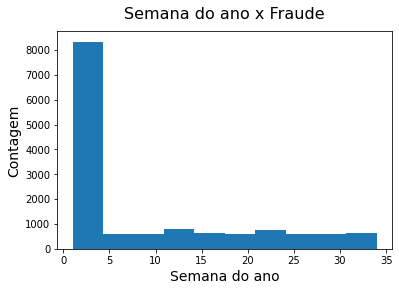

In [25]:
tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel('Semana do ano', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Semana do ano x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

### Engenharia de recursos

In [26]:
userid_count3 = fraude_df.groupby(by=['id_dispositivo']).id.count()
fraude_df['id_por_dispositivo'] = fraude_df['id_dispositivo'].apply(lambda x: userid_count3[x])

userid_count4 = fraude_df.groupby(by=['ip']).id.count()
fraude_df['id_por_ip'] = fraude_df['ip'].apply(lambda x: userid_count4[x])

fraude_df['media_id'] = (fraude_df['id_por_dispositivo'] + fraude_df['id_por_ip']) * 0.5

for col in ['cadastro', 'compra']:
    fraude_df[col] = fraude_df[col].apply(pd.to_datetime)
    
fraude_df['tempo'] = (fraude_df['compra'] - fraude_df['cadastro']).apply(lambda x: x.seconds)
fraude_df.head(2)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,isp_count,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Único,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,Único,United States,1,1,1.0,17944


In [32]:
pais_dummies = pd.get_dummies(fraude_df['pais'], prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)

fraude_df.drop(['id', 'cadastro', 'compra', 'id_dispositivo', 'ip', 'id_por_dispositivo', 'id_por_ip', 'pais', 'fonte', 'browser', 
                'genero', 'idade', 'valor', 'isp_count'], axis=1, inplace=True)
fraude_df.head()

,fraude,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,1.0,-0.991735,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,-0.814503,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,12.0,-6.338850,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1.0,0.511309,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,-0.050474,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Seleção de recursos

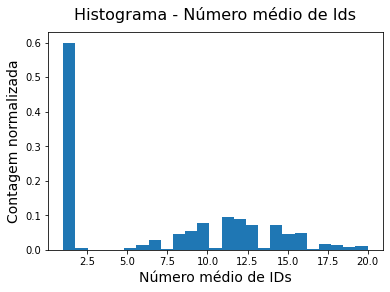

In [28]:
fraude_df[fraude_df['fraude'] == 1].media_id.hist(density=True, bins=25)
plt.xlabel('Número médio de IDs', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Número médio de Ids', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

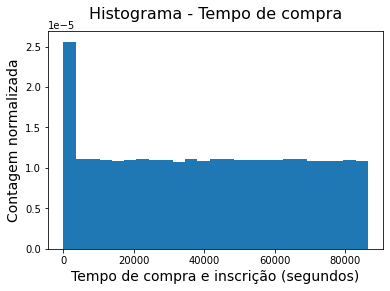

In [29]:
fraude_df['tempo'].hist(density=True, bins=25)
plt.xlabel('Tempo de compra e inscrição (segundos)', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Tempo de compra', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

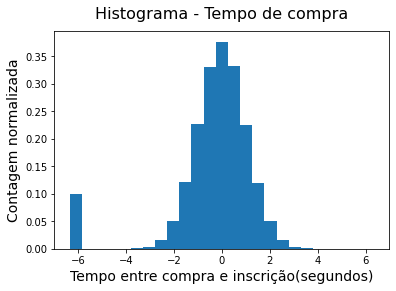

In [30]:
def rescale_series(serie):
    serie_min = serie.min() - 1e-5
    serie_max = serie.max() + 1e-5
    new_serie = (serie - serie_min) / (serie_max - serie_min)
    new_serie = new_serie.apply(lambda x: np.sqrt(2)*special.erfinv(2*x - 1))
    return new_serie

fraude_df['tempo'] = rescale_series(fraude_df['tempo'])
fraude_df['tempo'].hist(density=True, bins=25)
plt.xlabel('Tempo entre compra e inscrição(segundos)', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Tempo de compra', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

Identificando variáveis importantes

In [36]:
def rescale_series(serie):
    return (serie - serie.min()) / (serie.max() - serie.min())

one_hot_encoded = [feature for feature in fraude_df.columns if 'pais' not in feature and feature != 'fraude']

for col in one_hot_encoded:
    fraude_df[col] = rescale_series(fraude_df[col])

X = fraude_df[[col for col in fraude_df.columns if col != 'fraude']]
Y = fraude_df['fraude']

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
_ = clf.fit(X, Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_
features [features['importancia'] > np.mean(features['importancia'])].sort_values(by='importancia', ascending=False)

,feature,importancia
1,tempo,0.688754
0,media_id,0.305716
